<a href="https://colab.research.google.com/github/sechmo/IA-minirobots-2023-II/blob/master/5.%20Redes%20Neuronales/3.%20MEPX/mepx_soybeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Soybean classification with Neural Networks

We are going to give a try to the dataset soybeans from MEPX using neural networks, the dataset seems to originate from

Michalski, R.S. and Chilausky, R.L. (1988). Soybean (Large). UCI Machine Learning Repository. https://doi.org/10.24432/C5JG6Z.



We are going to use pytorch to train the network

In [33]:
from torch.utils.data import DataLoader, Dataset

import torch
import torch.nn as nn
import torch.utils.data as da
import pandas as pd
import matplotlib.pyplot as plt

In [34]:
torch.__version__

'2.1.0+cu118'

We choose the best hardware available

In [35]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Data loading

We read the data using pandas, this datasetet is not very large and has many dimensions, so its going to be difficult to teach the model to predict the class.

In [36]:
training_df = pd.read_csv('./training_data.csv',sep=' ',header=None)
test_df = pd.read_csv('./test_data.csv',sep=' ',header=None)
training_df

,0,1,2,3,4,5,6,7,8,9,...,73,74,75,76,77,78,79,80,81,82
0,0.000000,1,0,0,0.5,0,1,0,0.333333,0,...,0,0,0,0,0,1,0,0,0,15
1,0.500000,1,0,0,0.5,0,1,0,0.000000,0,...,0,0,0,0,0,1,0,0,0,9
2,0.666667,0,0,1,0.0,1,0,1,0.333333,0,...,1,1,0,0,1,0,0,1,0,1
3,0.166667,1,1,0,0.0,0,1,0,1.000000,0,...,0,0,0,0,0,1,0,0,0,15
4,0.166667,1,0,0,1.0,0,0,1,0.000000,0,...,0,1,0,1,0,1,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,0.000000,0,0,1,0.0,1,0,1,0.000000,1,...,1,0,1,0,1,1,0,0,0,3
509,0.333333,1,0,0,0.5,0,1,0,0.666667,0,...,0,0,0,0,0,1,0,0,0,9
510,0.833333,1,1,0,1.0,0,1,0,1.000000,0,...,0,0,0,0,0,1,0,0,0,16
511,0.500000,1,1,0,0.5,0,0,0,0.000000,0,...,0,0,0,0,0,1,0,0,0,17


In [37]:
NUM_CHARS = training_df.values.shape[1]-1
NUM_CLASSES = len(set(training_df.values[:,-1]))
print(f"We are using {NUM_CHARS} characteristics to classify among {NUM_CLASSES} classes")

We are using 82 characteristics to classify among 19 classes


We load the data to the hardware (in case its a GPU or TPU)

In [38]:
training_data_tensor = torch.from_numpy(training_df.values[:,:-1]).to(torch.float32).to(device)
training_labels_tensor = torch.from_numpy(training_df.values[:,-1]).to(torch.int64).to(device)

test_data_tensor = torch.from_numpy(test_df.values[:,:-1]).to(torch.float32).to(device)
test_labels_tensor = torch.from_numpy(test_df.values[:,-1]).to(torch.int64).to(device)

We did some test normalizing the data, but results were worst

In [39]:
from sklearn import preprocessing

In [40]:
#training_data_tensor = nn.functional.normalize(training_data_tensor)
#test_data_tensor = nn.functional.normalize(test_data_tensor)

We create the pytorch datasets and dataloaders

In [41]:
training_ds = da.TensorDataset(training_data_tensor,training_labels_tensor)
test_ds = da.TensorDataset(test_data_tensor,test_labels_tensor)

In [42]:
batch_size = 64
training_dl = da.DataLoader(training_ds, batch_size=batch_size, shuffle=True)
test_dl = da.DataLoader(test_ds, batch_size=batch_size, shuffle=True)

# Training and testing routines

In [43]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        print(pred.shape,y.shape)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct,test_loss

# The neural network

After many attempts, best results arise with the use of few layers, keeping dimensionality adn using Tanh activation

In [44]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        #self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(NUM_CHARS, NUM_CHARS),
            nn.Tanh(),
            nn.Linear(NUM_CHARS, NUM_CHARS),
            nn.Tanh(),
            nn.Linear(NUM_CHARS, NUM_CLASSES)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=82, out_features=82, bias=True)
    (1): Tanh()
    (2): Linear(in_features=82, out_features=82, bias=True)
    (3): Tanh()
    (4): Linear(in_features=82, out_features=19, bias=True)
  )
)


# Metaparamenters

The model takes some time to train, many epochs and a big learning rate works best. It takes some time in the sense that need many epochs, but if you are using an environment like Google Colab T4s, the 40 epochs run in about a second.

In [45]:
learning_rate = 1e-3
epochs = 40

We are using stochastic gradient descent to optimize our model

In [46]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

For this is a classification problem, we are going to use Cross Entropy as our loss function

In [47]:
loss_fn = nn.CrossEntropyLoss()

# Training

Learning stability is not great, the model sometimes gets up to 40% accuracy, but generally ranges between 10% and 30%

In [48]:
accuracies = []
losses = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(training_dl, model, loss_fn, optimizer)
    acc, loss = test(test_dl, model, loss_fn)
    accuracies.append(acc)
    losses.append(loss)
print("Done!")

Epoch 1
-------------------------------
torch.Size([64, 19]) torch.Size([64])
loss: 2.874963  [   64/  513]
torch.Size([64, 19]) torch.Size([64])
torch.Size([64, 19]) torch.Size([64])
torch.Size([64, 19]) torch.Size([64])
torch.Size([64, 19]) torch.Size([64])
torch.Size([64, 19]) torch.Size([64])
torch.Size([64, 19]) torch.Size([64])
torch.Size([64, 19]) torch.Size([64])
torch.Size([1, 19]) torch.Size([1])
Test Error: 
 Accuracy: 12.4%, Avg loss: 2.891407 

Epoch 2
-------------------------------
torch.Size([64, 19]) torch.Size([64])
loss: 2.897654  [   64/  513]
torch.Size([64, 19]) torch.Size([64])
torch.Size([64, 19]) torch.Size([64])
torch.Size([64, 19]) torch.Size([64])
torch.Size([64, 19]) torch.Size([64])
torch.Size([64, 19]) torch.Size([64])
torch.Size([64, 19]) torch.Size([64])
torch.Size([64, 19]) torch.Size([64])
torch.Size([1, 19]) torch.Size([1])
Test Error: 
 Accuracy: 12.4%, Avg loss: 2.891829 

Epoch 3
-------------------------------
torch.Size([64, 19]) torch.Size([64]

# Results

Even if our model did not get to a near 100% accuracy, it does indeed learns something as if it were simply guessing randomly it would have a $1/19 \approx 5.3 \%$ accuracy. Reaching 30% or even 40% on some training runs is a 6-8x improvement. Accuracy increments stagnates around 30 epochs, however loss keeps going down, yet it is between a relatively small range $≈ [2.7 , 2.9]$ so decrease isn't significant enough to keeps trying with many more epochs

Text(0.5, 1.0, 'Accuracy vs Epoch')

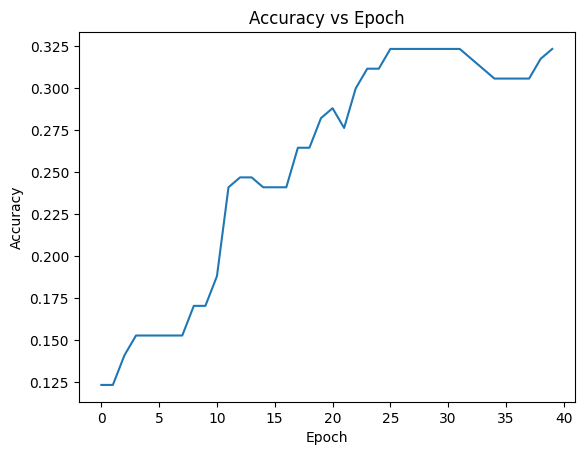

In [52]:
plt.plot(accuracies)
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.title("Accuracy vs Epoch")

Text(0.5, 1.0, 'Lossy vs Epoch')

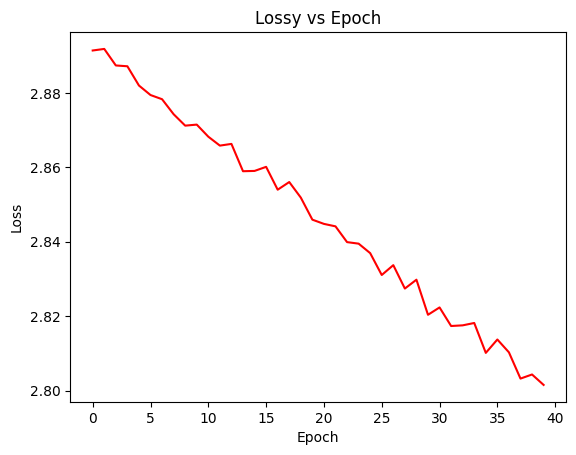

In [55]:
plt.plot(losses, c='red')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Lossy vs Epoch")